## Basic Feedforward Neural Network From Scratch

---

### Project Overview

This report aims to build a fully custom feedforward neural network framework using Python and NumPy, which will be accomplished namely by:

1. Implementing core components such as layers, activation functions, loss functions, and an optimiser
2. Demonstrating training on a sample dataset, visualize performance, and compare results against a baseline
3. Exploring advanced features like different optimisers, regularization, and potential improvements

---
## Table of Contents
---
##### 1. Imports and Setup
##### 2. Activation and Derivatives
##### 3. Loss Functions
##### 4. Optimisers from Scratch
##### 5. Feedforward Network Implementations
##### $~~~~~$ 5.1 ElementWiseFFN: Manual "per-neuron" approach
##### $~~~~~$ 5.2 MatrixFFN: 2-layer network (hidden + output) with matrices
##### $~~~~~$ 5.3 MultiLayerFFN: Arbitrary multi-layer (fully connected) NN
##### 6. Data Generation
##### 7. Training Demonstration
##### $~~~~~$ 7.1 Training for Elementwise FFN
##### $~~~~~$ 7.2 Training for MatrixFFN
##### $~~~~~$ 7.3 Training for MultiLayerFFN
##### 8. Main Execution
---

## 1. Imports and Setup

Below, we load the necessary Python libraries for matrix operations, plotting, and performance tracking

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import logging
from typing import List, Tuple, Dict, Union

# for repproducibility 
np.random.seed(42)

## 2. Activation and Derivatives

First we try the sigmoid function, chosen for its smooth gradient, which is useful in binary classification:  


Sigmoid Equation:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
Sigmoid Derivative x:
$$
\sigma'(x) = \sigma(x)\left(1 - \sigma(x)\right)
$$

Then we also try ReLU (Rectified Linear Unit), which is favoured for its simplicity and to mitigate vanishing gradient issues in deep networks:  

ReLu Equation:
$$
\text{ReLU}(x) = \max(0, x)
$$
ReLu Derivative:
$$
\text{ReLU}'(x) =
\begin{cases}
1, & \text{if } x > 0, \\
0, & \text{otherwise}.
\end{cases}
$$

In [13]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """Sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-x))  # No change in logic

def sigmoid_deriv(x: np.ndarray) -> np.ndarray:
    """
    Computes the derivative of the sigmoid function.

    d/dx(sigmoid(x)) = sigmoid(x) * (1 - sigmoid(x))
    """
    s = sigmoid(x)
    return s * (1.0 - s)

def relu(x: np.ndarray) -> np.ndarray:
    """ReLU activation function."""
    return np.maximum(0, x)

def relu_deriv(x: np.ndarray) -> np.ndarray:
    """Derivative of the ReLU activation function."""
    grad = np.zeros_like(x)
    grad[x > 0] = 1
    return grad

# def softmax(logits: np.ndarray) -> np.ndarray:
#     """
#     Numerically stable softmax for vectors or 2D arrays.
#     If input is 2D, applies row-wise.

#     Args:
#         logits (np.ndarray): Input array of shape (N,) or (N, M).

#     Returns:
#         np.ndarray: Softmax probabilities with the same shape as logits.
#     """
#     shifted = logits - np.max(logits, axis=-1, keepdims=True)
#     exps = np.exp(shifted)
#     return exps / np.sum(exps, axis=-1, keepdims=True)

## 3. Loss Functions

---
For loss functions, we can start with Mean Squared Error(MSE) which although is more common in regression, it’s implemented for demonstration:

MSE Equation:
$$
\text{MSE}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - \hat{y}_i\right)^2
$$

Code for above MSE equations:

In [18]:
def mse_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Squared Error (MSE) loss."""
    return np.mean((y_true - y_pred)**2)

def mse_deriv(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """Derivative of MSE with respect to y_pred."""
    return -2.0 * (y_true - y_pred) / y_true.shape[0]

---
We can also experiment with Binary Cross Entropy(BCE) which is typically preferred for binary classification tasks:

BCE Equation:
$$
\text{BCE}(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]
$$

Code for above BCE equations:

In [22]:
def binary_cross_entropy_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Binary Cross Entropy (BCE) loss for binary classification with single-output-sigmoid.
    """
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1.0 - y_pred))

def binary_cross_entropy_deriv(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """
    Derivative of the binary cross entropy loss with respect to y_pred.
    """
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    return ((-y_true / y_pred) + ((1.0 - y_true) / (1.0 - y_pred))) / y_true.shape[0]

## 4. Optimisers from Scratch

Class for optimiser:

In [25]:
class OptimiserBase:
    """Base class for all optimisers."""
    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        raise NotImplementedError("step method must be implemented by subclass optimisers.")

---
We can start off with the basic baseline optimiser, Stochastic Gradient Descent(SGD) which is simple and intuitive:

SGD Update Rule:
$$
\theta = \theta - \eta \nabla L(\theta)
$$

Code for SGD:

In [29]:
class SGD(OptimiserBase):
    """
    Stochastic Gradient Descent with no momentum.

    Attributes:
        lr (float): Learning rate.
    """
    def __init__(self, lr: float = 0.01):
        self.lr = lr

    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        for p, g in zip(params, grads):
            p -= self.lr * g

---

We can take it one step further an try SGD with Momentum, which helps to smooth out the updates and accelerate training:

SGD with Momentum Update Rule:
$$
\begin{aligned}
v &= \mu v - \eta \nabla L(\theta), \\
\theta &= \theta + v.
\end{aligned}
$$

Code for SGD with Momentum:

In [34]:
class SGDWithMomentum(OptimiserBase):
    """
    Stochastic Gradient Descent with Momentum.
    v = momentum * v - lr * grad
    param += v
    """
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None  # Initialize after seeing param shapes

    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        if self.v is None:
            self.v = [np.zeros_like(p) for p in params]

        for i, (p, g) in enumerate(zip(params, grads)):
            self.v[i] = self.momentum * self.v[i] - self.lr * g
            p += self.v[i]

---

Lastly we can experiment with Adam Optimiser, which essentially combines momentum and adaptive learning rates:

Key Equations for Adam Optimiser:
$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) \nabla L(\theta), \\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) \left(\nabla L(\theta)\right)^2, \\
\hat{m}_t &= \frac{m_t}{\,1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{\,1-\beta_2^t}, \\
\theta &= \theta - \eta \, \frac{\hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon}.
\end{aligned}
$$

Code for Adam Optimiser:

In [39]:
class Adam(OptimiserBase):
    """
    Adam optimiser from scratch.

    Attributes:
        lr (float): Learning rate.
        beta1 (float): Exponential decay rate for the first moment.
        beta2 (float): Exponential decay rate for the second moment.
        eps (float): Small constant to avoid division by zero.
    """
    def __init__(self, lr: float = 0.001, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = None
        self.v = None

    def step(self, params: List[np.ndarray], grads: List[np.ndarray]):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]

        self.t += 1
        for i, (p, g) in enumerate(zip(params, grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            p -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

## 5. Feedforward Network Implementations

#### 5.1 ElementWiseFFN: Manual "per-neuron" approach

This implementation demonstrates the network’s inner workings at the neuron level. Although gradients are placeholders here, it serves as an educational tool. Two inputs, two hidden neurons, and one output neuron with sigmoid activations to keep the network architecture simple and interpretable.

Equation for:  

$~~~~~~~~$ Hidden Neuron:
$$
h = \sigma(w_1 x_1 + w_2 x_2 + b)
$$
$~~~~~~~~$ Output Neuron:
$$
o = \sigma(w_3 h_1 + w_4 h_2 + b_o)
$$

In [45]:
class ElementWiseFFN:
    """
    A simple neural network with:
      - 2 inputs
      - 2 hidden neurons
      - 1 output neuron
      - Sigmoid activations

    Forward pass uses elementwise computations, reminiscent of original examples.
    """

    def __init__(self):
        # Weights
        self.w1 = np.random.randn()
        self.w2 = np.random.randn()
        self.w3 = np.random.randn()
        self.w4 = np.random.randn()
        self.w5 = np.random.randn()
        self.w6 = np.random.randn()
        # Biases
        self.b1 = np.random.randn()
        self.b2 = np.random.randn()
        self.b3 = np.random.randn()

    def parameters(self) -> List[np.ndarray]:
        """
        Returns:
            List[np.ndarray]: A list of all parameters for easy optimization.
        """
        return [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6,
                self.b1, self.b2, self.b3]

    def forward(self, x: np.ndarray) -> float:
        """
        Single-sample forward pass.

        Args:
            x (np.ndarray): Input of shape (2,).

        Returns:
            float: Single scalar output (sigmoid).
        """
        sum_h1 = self.w1 * x[0] + self.w2 * x[1] + self.b1
        h1 = sigmoid(sum_h1)

        sum_h2 = self.w3 * x[0] + self.w4 * x[1] + self.b2
        h2 = sigmoid(sum_h2)

        sum_o1 = self.w5 * h1 + self.w6 * h2 + self.b3
        o1 = sigmoid(sum_o1)

        return o1

    def forward_batch(self, X: np.ndarray) -> np.ndarray:
        """
        Batch forward pass.

        Args:
            X (np.ndarray): Input of shape (batch_size, 2).

        Returns:
            np.ndarray: Network outputs of shape (batch_size,).
        """
        return np.array([self.forward(x) for x in X])

#### 5.2 MatrixFFN: 2-layer network (hidden + output) with matrices

Uses matrix multiplications to compute the activations, which is much more efficient for larger datasets. A hidden layer of configurable size (e.g., 𝐻 = 4) and a single output neuron. Hidden activations use ReLU (to combat vanishing gradients) while the output uses sigmoid.

Forward Pass Equation for:

$~~~~~~~~$ Hidden Layer:
$$
z_1 = XW_1 + b_1,\quad h = \text{ReLU}(z_1)
$$
$~~~~~~~~$ Output Layer:
$$
z_2 = hW_2 + b_2,\quad \hat{y} = \sigma(z_2)
$$

In [50]:
class MatrixFFN:
    """
    A 2-layer feedforward network:
      - Input layer: dimension D_in
      - Hidden layer: dimension H
      - Output layer: dimension D_out

    Uses standard matrix multiplications for forward/backward passes.
    """

    def __init__(self, D_in: int, H: int, D_out: int, activation: str = 'sigmoid'):
        self.D_in = D_in
        self.H = H
        self.D_out = D_out

        # Initialize weights
        self.W1 = np.random.randn(D_in, H)
        self.b1 = np.random.randn(H)
        self.W2 = np.random.randn(H, D_out)
        self.b2 = np.random.randn(D_out)

        if activation == 'sigmoid':
            self.act = sigmoid
            self.act_deriv = sigmoid_deriv
        elif activation == 'relu':
            self.act = relu
            self.act_deriv = relu_deriv
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def parameters(self) -> List[np.ndarray]:
        """Return all trainable parameters."""
        return [self.W1, self.b1, self.W2, self.b2]

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass.

        Args:
            X (np.ndarray): Input array of shape (batch_size, D_in).

        Returns:
            np.ndarray: Output array of shape (batch_size, D_out).
        """
        z1 = X.dot(self.W1) + self.b1
        h = self.act(z1)
        z2 = h.dot(self.W2) + self.b2
        out = sigmoid(z2)  # final output layer uses sigmoid
        return out


#### 5.3 MultiLayerFFN: Arbitrary multi-layer (fully connected) NN

This allows an arbitrary number of layers and neurons, making it easy to experiment with deeper architectures and layers are defined through a configuration list.

Each layer then computes:
$$
z = A^{\text{prev}} W + b,\quad A = \text{act}(z)
$$

And backpropagation is implemented in a loop through the layers (in reverse order) to compute gradients.

In [55]:
class MultiLayerFFN:
    """
    A fully-connected feedforward network with arbitrary layers, from scratch.

    Example usage:
        layers_config = [
            {"in": 2, "out": 4, "activation": "relu"},
            {"in": 4, "out": 3, "activation": "relu"},
            {"in": 3, "out": 1, "activation": "sigmoid"}
        ]
        model = MultiLayerFFN(layers_config)
    """

    def __init__(self, layer_configs: List[Dict[str, Union[int, str]]]):
        """
        Args:
            layer_configs (List[Dict[str, Union[int, str]]]): Each dict must contain:
                - "in": (int)  Input dimension of the layer
                - "out": (int) Output dimension of the layer
                - "activation": (str) "relu" or "sigmoid"
        """
        ### CHANGED: Logging the creation of the network
        logging.debug("Initializing MultiLayerFFN with layer configurations.")
        self.layers = []
        for cfg in layer_configs:
            W = np.random.randn(cfg["in"], cfg["out"])
            b = np.random.randn(cfg["out"])

            if cfg["activation"] == "sigmoid":
                act = sigmoid
                act_deriv = sigmoid_deriv
            elif cfg["activation"] == "relu":
                act = relu
                act_deriv = relu_deriv
            else:
                raise ValueError("Unsupported activation: {}".format(cfg["activation"]))

            self.layers.append({
                "W": W,
                "b": b,
                "act": act,
                "act_deriv": act_deriv
            })

    def parameters(self) -> List[np.ndarray]:
        """
        Collect all parameters (W, b for each layer) into a single list.

        Returns:
            List[np.ndarray]: List of all weights and biases in order.
        """
        params = []
        for layer in self.layers:
            params.append(layer["W"])
            params.append(layer["b"])
        return params

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass across all layers.

        Args:
            X (np.ndarray): Input of shape (batch_size, layer_configs[0]["in"]).

        Returns:
            np.ndarray: Output of shape (batch_size, layer_configs[-1]["out"]).
        """
        out = X
        for layer in self.layers:
            W, b, act = layer["W"], layer["b"], layer["act"]
            z = out.dot(W) + b
            out = act(z)
        return out


## 6. Data Generation

A synthetic 2D classification dataset consisting of two interleaved spirals. I went for spirals since they provide a non-linearly separable dataset, challenging the network to learn complex decision boundaries. For each class, the radius increases linearly and the angle is computed to generate a spiral. A low noise factor (0.05) is added to ensure the dataset is not too noisy while still being realistic.

In [58]:
def make_classification_data(n_samples=200, seed=42):
    """
    Generates a 2D synthetic classification dataset with two interleaved spirals.
    This version is *less challenging* than the original by reducing the noise
    and lowering the number of rotations in the spiral.
    """
    np.random.seed(seed)

    n_class0 = n_samples // 2
    n_class1 = n_samples - n_class0

    X = []
    y = []

    # Generate points for class 0 spiral
    for i in range(n_class0):
        r = 5.0 * (i / n_class0)               # radius grows with i
        theta = 1.0 * (i / n_class0) * 2 * np.pi  # fewer turns (changed from 1.75)
        # Reduced noise multiplier from 0.2 to 0.05
        x_coord = r * np.sin(theta) + np.random.randn() * 0.05
        y_coord = r * np.cos(theta) + np.random.randn() * 0.05

        X.append([x_coord, y_coord])
        y.append(0)

    # Generate points for class 1 spiral
    for i in range(n_class1):
        r = 5.0 * (i / n_class1)
        # Shift the angle by pi to interleave the spirals
        theta = 1.0 * (i / n_class1) * 2 * np.pi + np.pi
        x_coord = r * np.sin(theta) + np.random.randn() * 0.05
        y_coord = r * np.cos(theta) + np.random.randn() * 0.05

        X.append([x_coord, y_coord])
        y.append(1)

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    perm = np.random.permutation(n_samples)
    X = X[perm]
    y = y[perm]

    return X, y

A diagrammatic visualisation showing how a randomly generated dataset of 500 samples appears:

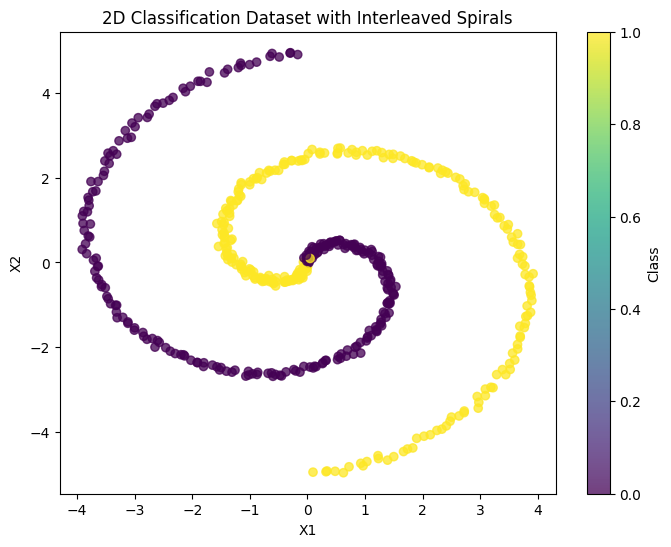

In [60]:
X, y = make_classification_data(n_samples=500)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.75)
plt.title("2D Classification Dataset with Interleaved Spirals")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Class")
plt.show()

## 7. Training Demonstration

Plot function for visualisation

In [63]:
import os

def plot_history(loss_history: List[float], acc_history: List[float], title: str):
    epochs = np.arange(1, len(loss_history) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history, label="Accuracy", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

#### 7.1 Training for Elementwise FFN

In [65]:
def train_elementwise_ffn():
    print("\n===== ElementWiseFFN Training =====")
    X, y = make_classification_data(n_samples=100)

    model = ElementWiseFFN()
    loss_history = []
    acc_history = []
    loss = []
    rows = []

    header = "+-------+----------+----------+"
    print(header)
    print("| Epoch |   Loss   | Accuracy |")
    print(header)

    def forward_batch_fn(X_batch: np.ndarray) -> np.ndarray:
        return model.forward_batch(X_batch)

    def compute_loss_grad(X_batch: np.ndarray, y_batch: np.ndarray) -> Tuple[float, List[float]]:
        y_pred = forward_batch_fn(X_batch)
        loss_val = binary_cross_entropy_loss(y_batch, y_pred)
        dL_dy = binary_cross_entropy_deriv(y_batch, y_pred)

        d_w1 = d_w2 = d_w3 = d_w4 = d_w5 = d_w6 = 0.0
        d_b1 = d_b2 = d_b3 = 0.0

        for i in range(len(X_batch)):
            x_i = X_batch[i]
            dL_dy_i = dL_dy[i]

            sum_h1 = model.w1 * x_i[0] + model.w2 * x_i[1] + model.b1
            h1 = sigmoid(sum_h1)
            sum_h2 = model.w3 * x_i[0] + model.w4 * x_i[1] + model.b2
            h2 = sigmoid(sum_h2)
            sum_o1 = model.w5 * h1 + model.w6 * h2 + model.b3
            o1 = sigmoid(sum_o1)

            d_ypred_d_sum_o1 = sigmoid_deriv(sum_o1)
            d_sum_o1_d_w5 = h1
            d_sum_o1_d_w6 = h2
            d_sum_o1_d_b3 = 1.0

            d_sum_o1_d_h1 = model.w5
            d_sum_o1_d_h2 = model.w6

            d_h1_d_sum_h1 = sigmoid_deriv(sum_h1)
            d_sum_h1_d_w1 = x_i[0]
            d_sum_h1_d_w2 = x_i[1]

            d_h2_d_sum_h2 = sigmoid_deriv(sum_h2)
            d_sum_h2_d_w3 = x_i[0]
            d_sum_h2_d_w4 = x_i[1]

            dL_d_sum_o1 = dL_dy_i * d_ypred_d_sum_o1

            d_w5 += dL_d_sum_o1 * d_sum_o1_d_w5
            d_w6 += dL_d_sum_o1 * d_sum_o1_d_w6
            d_b3 += dL_d_sum_o1 * d_sum_o1_d_b3

            dL_d_h1 = dL_d_sum_o1 * d_sum_o1_d_h1
            dL_d_h2 = dL_d_sum_o1 * d_sum_o1_d_h2

            dL_d_sum_h1 = dL_d_h1 * d_h1_d_sum_h1
            d_w1 += dL_d_sum_h1 * d_sum_h1_d_w1
            d_w2 += dL_d_sum_h1 * d_sum_h1_d_w2
            d_b1 += dL_d_sum_h1

            dL_d_sum_h2 = dL_d_h2 * d_h2_d_sum_h2
            d_w3 += dL_d_sum_h2 * d_sum_h2_d_w3
            d_w4 += dL_d_sum_h2 * d_sum_h2_d_w4
            d_b2 += dL_d_sum_h2

        bs = len(X_batch)
        grads = [
            d_w1 / bs, d_w2 / bs, d_w3 / bs, d_w4 / bs, d_w5 / bs, d_w6 / bs,
            d_b1 / bs, d_b2 / bs, d_b3 / bs
        ]
        return loss_val, grads

    # ### CHANGED: Using Adam with a higher LR for demonstration
    optimiser = Adam(lr=0.05)
    n_epochs = 1000
    batch_size = 10
    
    for epoch in range(n_epochs):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            loss_val, grads = compute_loss_grad(X_batch, y_batch)
            params = model.parameters()
            optimiser.step(params, grads)
        y_pred_full = model.forward_batch(X)
        loss_epoch = binary_cross_entropy_loss(y, y_pred_full)
        preds_label = (y_pred_full >= 0.5).astype(int)
        acc = np.mean(preds_label == y)
        loss_history.append(loss_epoch)
        acc_history.append(acc)
        rows.append((epoch+1, float(loss_epoch), float(acc)))
        ep, ls, ac = rows[-1]
        print("| {:5d} | {:8.4f} | {:8.4f} |".format(ep, ls, ac))
        print(header)

    plot_history(loss_history, acc_history, "ElementWiseFFN")

#### 7.2 Training for MatrixFFN

In [67]:
def train_matrix_ffn():
    print("\n===== MatrixFFN Training =====")
    X, y = make_classification_data(n_samples=200)
    y = y.reshape(-1, 1)

    model = MatrixFFN(D_in=2, H=4, D_out=1, activation='relu')
    loss_history = []
    acc_history = []
    rows = []

    optimiser = SGDWithMomentum(lr=0.01, momentum=0.9)

    n_epochs = 1000
    batch_size = 20
    
    header = "+-------+----------+----------+"
    print(header)
    print("| Epoch |   Loss   | Accuracy |")
    print(header)

    for epoch in range(n_epochs):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]

        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            y_pred = model.forward(X_batch)
            loss_val = binary_cross_entropy_loss(y_batch, y_pred)
            dL_dy_pred = binary_cross_entropy_deriv(y_batch, y_pred)

            z1 = X_batch.dot(model.W1) + model.b1
            if model.act == relu:
                h = relu(z1)
            else:
                h = sigmoid(z1)

            z2 = h.dot(model.W2) + model.b2
            s2 = sigmoid(z2)

            d_sig = s2 * (1.0 - s2)
            dL_dz2 = dL_dy_pred * d_sig

            grad_W2 = h.T.dot(dL_dz2)
            grad_b2 = np.sum(dL_dz2, axis=0)

            dL_dh = dL_dz2.dot(model.W2.T)
            if model.act == relu:
                d_relu = relu_deriv(z1)
                dL_dz1 = dL_dh * d_relu
            else:
                d_sig1 = sigmoid_deriv(z1)
                dL_dz1 = dL_dh * d_sig1

            grad_W1 = X_batch.T.dot(dL_dz1)
            grad_b1 = np.sum(dL_dz1, axis=0)

            grads = [grad_W1, grad_b1, grad_W2, grad_b2]
            optimiser.step(model.parameters(), grads)

        y_pred_full = model.forward(X)
        loss_epoch = binary_cross_entropy_loss(y, y_pred_full)
        preds_label = (y_pred_full >= 0.5).astype(int)
        acc = np.mean(preds_label.flatten() == y.flatten())
        loss_history.append(loss_epoch)
        acc_history.append(acc)
        rows.append((epoch+1, float(loss_epoch), float(acc)))
        ep, ls, ac = rows[-1]
        print("| {:5d} | {:8.4f} | {:8.4f} |".format(ep, ls, ac))
        print(header)

    plot_history(loss_history, acc_history, "MatrixFFN")

#### 7.3 Training for MultiLayerFFN

In [69]:
def train_multi_layer_ffn():
    print("\n===== MultiLayerFFN Training =====")
    X, y = make_classification_data(n_samples=300)
    y = y.reshape(-1, 1)
    layers_config = [
        {"in": 2, "out": 5, "activation": "relu"},
        {"in": 5, "out": 3, "activation": "relu"},
        {"in": 3, "out": 1, "activation": "sigmoid"}
    ]
    model = MultiLayerFFN(layers_config)
    loss_history = []
    acc_history = []
    rows = []

    optimiser = Adam(lr=0.01)

    header = "+-------+----------+----------+"
    print(header)
    print("| Epoch |   Loss   | Accuracy |")
    print(header)

    def forward_detailed(X_batch: np.ndarray):
        z_vals = []
        a_vals = []
        a_in = X_batch
        for layer in model.layers:
            W, b, act = layer["W"], layer["b"], layer["act"]
            z = a_in.dot(W) + b
            a_out = act(z)
            z_vals.append(z)
            a_vals.append(a_out)
            a_in = a_out
        return z_vals, a_vals

    def backprop(X_batch: np.ndarray, y_batch: np.ndarray) -> Tuple[float, List[np.ndarray]]:
        z_vals, a_vals = forward_detailed(X_batch)
        y_pred = a_vals[-1]
        loss_val = binary_cross_entropy_loss(y_batch, y_pred)
        dL_dy = binary_cross_entropy_deriv(y_batch, y_pred)
        grads_W = [None] * len(model.layers)
        grads_b = [None] * len(model.layers)
        dA = dL_dy
        for i in reversed(range(len(model.layers))):
            layer = model.layers[i]
            W, b, act, act_deriv = layer["W"], layer["b"], layer["act"], layer["act_deriv"]
            z = z_vals[i]
            A_in = X_batch if i == 0 else a_vals[i - 1]
            dZ = dA * act_deriv(z)
            gradW = A_in.T.dot(dZ)
            gradb = np.sum(dZ, axis=0)
            grads_W[i] = gradW
            grads_b[i] = gradb
            dA = dZ.dot(W.T)
        grads = []
        for gw, gb in zip(grads_W, grads_b):
            grads.append(gw)
            grads.append(gb)
        return loss_val, grads

    n_epochs = 1000
    batch_size = 25

    for epoch in range(n_epochs):
        perm = np.random.permutation(len(X))
        X = X[perm]
        y = y[perm]
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            loss_val, grads = backprop(X_batch, y_batch)
            optimiser.step(model.parameters(), grads)
        y_pred_full = model.forward(X)
        loss_epoch = binary_cross_entropy_loss(y, y_pred_full)
        preds_label = (y_pred_full >= 0.5).astype(int)
        acc = np.mean(preds_label.flatten() == y.flatten())
        loss_history.append(loss_epoch)
        acc_history.append(acc)
        rows.append((epoch+1, float(loss_epoch), float(acc)))
        ep, ls, ac = rows[-1]
        print("| {:5d} | {:8.4f} | {:8.4f} |".format(ep, ls, ac))
        print(header)

    plot_history(loss_history, acc_history, "MultiLayerFFN")

## 8. Main Execution

In [71]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")


===== ElementWiseFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|     1 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     2 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     3 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     4 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     5 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     6 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     7 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     8 |   0.8868 |   0.5000 |
+-------+----------+----------+
|     9 |   0.8868 |   0.5000 |
+-------+----------+----------+
|    10 |   0.8868 |   0.5000 |
+-------+----------+----------+
|    11 |   0.8868 |   0.5000 |
+-------+----------+----------+
|    12 |   0.8868 |   0.5000 |
+-------+----------+----------+
|    13 |   0.8868 |   0.5000 |
+-------+----------+----------+
|    14 |   0.8868 |   0.5000 |
+--

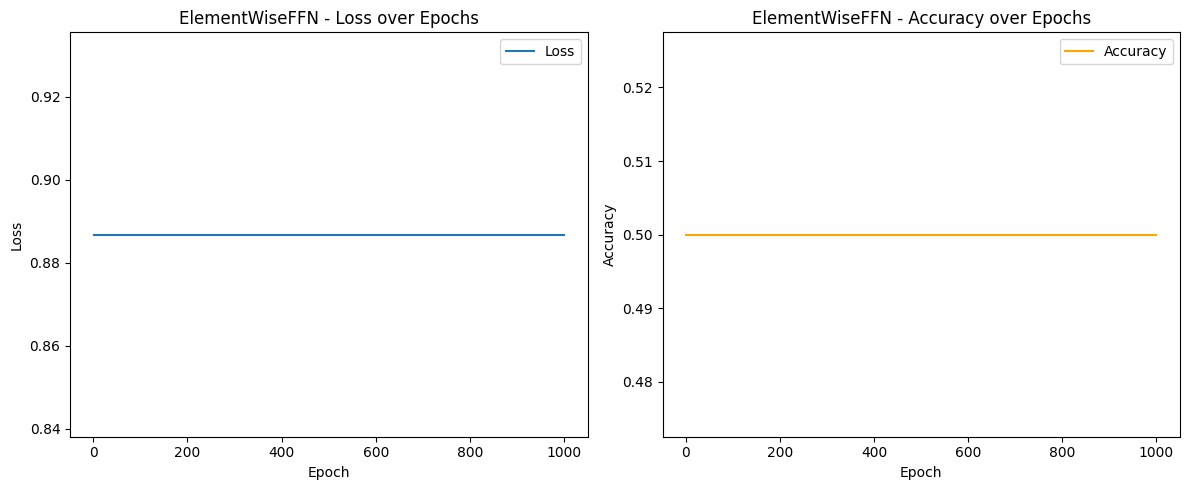

In [72]:
train_elementwise_ffn()


===== MatrixFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|     1 |   0.9926 |   0.3900 |
+-------+----------+----------+
|     2 |   0.8528 |   0.4700 |
+-------+----------+----------+
|     3 |   0.7624 |   0.5000 |
+-------+----------+----------+
|     4 |   0.7011 |   0.5000 |
+-------+----------+----------+
|     5 |   0.6645 |   0.5400 |
+-------+----------+----------+
|     6 |   0.6401 |   0.6500 |
+-------+----------+----------+
|     7 |   0.6221 |   0.6350 |
+-------+----------+----------+
|     8 |   0.6088 |   0.6200 |
+-------+----------+----------+
|     9 |   0.5988 |   0.6150 |
+-------+----------+----------+
|    10 |   0.5899 |   0.6150 |
+-------+----------+----------+
|    11 |   0.5810 |   0.6050 |
+-------+----------+----------+
|    12 |   0.5730 |   0.6100 |
+-------+----------+----------+
|    13 |   0.5672 |   0.6200 |
+-------+----------+----------+
|    14 |   0.5624 |   0.6050 |
+-------

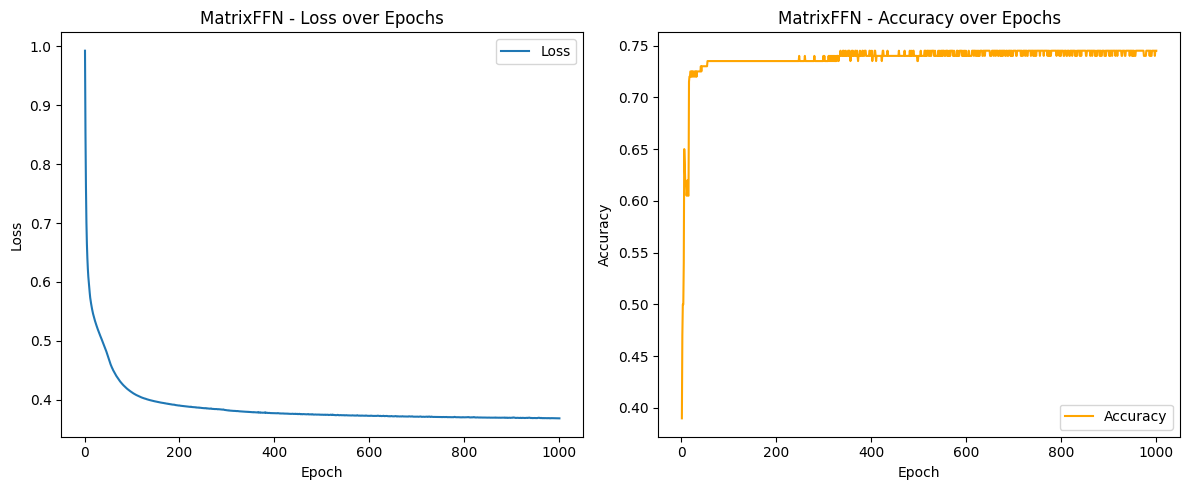

In [73]:
train_matrix_ffn()


===== MultiLayerFFN Training =====
+-------+----------+----------+
| Epoch |   Loss   | Accuracy |
+-------+----------+----------+
|     1 |   1.1155 |   0.5967 |
+-------+----------+----------+
|     2 |   0.9633 |   0.5833 |
+-------+----------+----------+
|     3 |   0.7794 |   0.6100 |
+-------+----------+----------+
|     4 |   0.6631 |   0.6333 |
+-------+----------+----------+
|     5 |   0.6104 |   0.6300 |
+-------+----------+----------+
|     6 |   0.5786 |   0.6367 |
+-------+----------+----------+
|     7 |   0.5462 |   0.6567 |
+-------+----------+----------+
|     8 |   0.5162 |   0.6600 |
+-------+----------+----------+
|     9 |   0.4914 |   0.6967 |
+-------+----------+----------+
|    10 |   0.4713 |   0.7233 |
+-------+----------+----------+
|    11 |   0.4603 |   0.7400 |
+-------+----------+----------+
|    12 |   0.4495 |   0.7400 |
+-------+----------+----------+
|    13 |   0.4398 |   0.7433 |
+-------+----------+----------+
|    14 |   0.4317 |   0.7467 |
+---

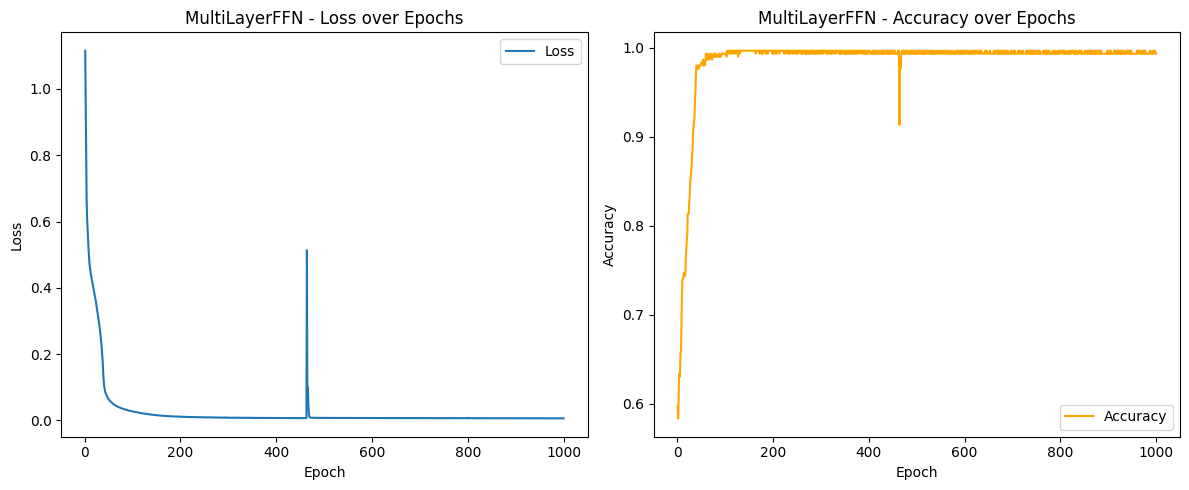

In [74]:
train_multi_layer_ffn()